In [113]:
# Módulos estándar de Python
import os
import sys

# Manipulación de datos
import numpy as np
import pandas as pd

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Preprocesamiento y transformación de datos - Scikit-learn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder

# División de datos y validación cruzada - Scikit-learn
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, learning_curve

# Encoders para variables categóricas
import category_encoders as ce
from category_encoders import TargetEncoder

# Modelos de regresión - Scikit-learn
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR, NuSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    ExtraTreesRegressor,
    HistGradientBoostingRegressor,
    BaggingRegressor,
    AdaBoostRegressor
)

# Redes neuronales - Scikit-learn
from sklearn.neural_network import MLPRegressor

# Modelos de boosting
from xgboost import XGBRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Distribuciones para búsqueda de hiperparámetros
from scipy.stats import uniform, randint

# Métricas de evaluación - Scikit-learn
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    root_mean_squared_error,
    root_mean_squared_log_error,
    make_scorer
)

### Importación de funciones personalizadas desde el directorio 'src'

In [114]:
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from regression_model import feature_importances, graficar_curva_aprendizaje_rmsle, calcular_metricas_rendimiento, revisar_predicciones

# Modelos de Regresión para la Predicción de **SalePrice**

Para la construcción de los modelos de regresión, se utilizó el conjunto de **train**, ya que el conjunto **test** no contiene valores en la variable objetivo (*target*), lo que impide evaluar el rendimiento del modelo directamente con las métricas.

Los datos fueron divididos en dos conjuntos: **train** y **validación**. Además, se empleó validación cruzada para obtener una evaluación más robusta y precisa del rendimiento del modelo.

Las predicciones generadas, `y_pred`, fueron comparadas con los valores reales, `y_val`, para evaluar el desempeño del modelo utilizando diversas métricas. Este proceso permitió identificar áreas de mejora, como ajustar el preprocesamiento de los datos o la selección de variables.

Se probaron varios modelos de regresión y se ajustaron hasta encontrar el que ofreciera las predicciones más cercanas a los valores reales. Finalmente, tras alcanzar un nivel de precisión satisfactorio, se aplicó el modelo al conjunto de datos de **test** y los resultados se guardaron en un archivo **.csv**.

Carga de los datos de entrenamiento y prueba desde archivos pickle.

In [115]:
train= pd.read_pickle('../data/train.pkl')
test= pd.read_pickle('../data/test.pkl')

## Eliminación de Columnas para los Modelos

Este procedimiento describe la eliminación de columnas del conjunto de datos basándose en las **importancias de características** (*feature importances*) menos relevantes. El objetivo principal es simplificar el modelo, eliminando aquellas columnas que no aportan valor significativo o que podrían impactar negativamente en su desempeño.  

El proceso se aplica de manera consistente en ambos subconjuntos de datos (entrenamiento y prueba) para garantizar que se mantengan alineados.

Las columnas que aparecen en esta lista, denominada `columnas_eliminar`, son el resultado del último modelo, lo que implica que podrían no ser las mismas que beneficiarían a otros modelos.

- **Columnas revisadas pero no eliminadas**:  
  Algunas columnas inicialmente clasificadas como poco relevantes se conservan tras comprobar que su eliminación empeora el modelo. Estas características pueden tener un impacto indirecto en el rendimiento del modelo.

```python
EnclosedPorch, LandContour, Foundation, MoSold, Street, LotShape, Neighborhood, ExterQual, ExterCond, 1stFlrSF, 2ndFlrSF, CentralAir, MasVnrType, MasVnrArea, BsmtHalfBath, Antigüedad_Remodelacion, TieneSotano.
```

In [116]:
columnas_eliminar = [
    "3SsnPorch",
    "Alley",
    "Antiguedad",
    "BañosTotales",
    "BedroomAbvGr",
    "BldgType",
    "BsmtFinSF2",
    "BsmtFinType2",
    "BsmtUnfSF",
    "Electrical",
    "Fence",
    "HasFireplaces",
    "HasGarage",
    "HasShed",
    "Heating",
    "HouseStyle",
    "KitchenAbvGr",
    "LandSlope",
    "LotConfig",
    "LowQualFinSF",
    "MiscVal",
    "NumeroSotanos",
    "PoolArea",
    "PoolQC",
    "RoofMatl",
    "RoofStyle",
    "SaleType",
    "ScreenPorch",
    "TienePiscina",
    "YrSold",
]
 
train.drop(columns=columnas_eliminar, inplace=True)
test.drop(columns=columnas_eliminar, inplace=True)

## División del conjunto de datos de train
Se define la target y las características X, se elimina Id ya que no es útil para el modelo

In [117]:
X = train.drop(['SalePrice', 'Id'], axis=1)
y = train['SalePrice']

# Identificación de Variables para Transformación Logarítmica 

En este proceso se identificaron las variables que podían beneficiarse de la aplicación de una transformación logarítmica, incluyendo la variable objetivo (precios de las casas). Esta transformación fue implementada en los modelos con la teoría de mejorar su desempeño.

En problemas donde las variables presentan un amplio rango de valores (por ejemplo, precios de casas que varían desde $50,000 hasta varios millones de dólares), los valores grandes pueden dominar el modelo y reducir la precisión de las predicciones. La transformación logarítmica permite reducir este efecto, equilibrando el impacto de los valores extremos y mejorando el rendimiento general del modelo.

Algunas variables, como los precios de las casas, presentan **distribuciones sesgadas**, con pocos valores extremadamente altos y una gran cantidad de valores pequeños. Al aplicar un logaritmo, los valores grandes se "acortan", lo que ayuda a que la distribución se aproxime a una forma más normal o simétrica.

Tras evaluar el modelo final `XGBRegressor` aplicando al conjunto de esas variables la transformación, se comprueba que la única variable que se ve beneficiada de esta transformación logarítmica es `SalePrice`.

In [84]:
columnas_logaritmo = [
    'LotArea', 'LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', 'EnclosedPorch', 
    '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
]

## Preparación del Modelo de Validación mediante la Comparación Inicial de Múltiples Modelos

# Modelos Seleccionados para la Prueba Inicial  

En la etapa inicial de pruebas, los modelos fueron divididos en dos grupos, dependiendo de si se benefician o no del escalado de las características

Modelos como `XGBRegressor`, `RandomForestRegressor`, `GradientBoostingRegressor`, `DecisionTreeRegressor`, `LGBMRegressor`, `CatBoostRegressor`, `BaggingRegressor`, o `AdaBoostRegressor` pueden entrenarse **sin necesidad de escalado** de las características. Esto se debe a que estos algoritmos, en su mayoría basados en árboles, utilizan divisiones en función de umbrales y no dependen de magnitudes absolutas o distancias.  

Por otro lado, hay modelos como `LinearRegression`, `Lasso`, `Ridge`, `SVR` o `KNeighborsRegressor`, que **dependen del escalado** de las características para funcionar correctamente. En estos casos, es fundamental que todas las variables tengan una escala similar para garantizar un buen desempeño.  

Se identificó que los **modelos que no requieren escalado** de las variables tienden a obtener mejores resultados en las pruebas iniciales. Esto podría deberse a que dichos modelos son menos sensibles a las distribuciones y escalas de las características, lo que los hace más robustos en diversas configuraciones de datos.  

### Validación cruzada

Se opta por hacer **validación cruzada** en lugar de una división fija del conjunto de datos en entrenamiento y validación. Con la validación cruzada, se puede obtener una evaluación más robusta del modelo al entrenarlo y validarlo en múltiples subdivisiones del conjunto de datos.

Se utilizó una validación cruzada con **10 divisiones** (*10-fold cross-validation*). Esto implica que el conjunto de datos se divide en 10 partes, y el modelo se entrena en 9 de ellas mientras se valida en la restante, repitiendo este proceso 10 veces, para mayor fiabilidad en la estimación del desempeño del modelo.  

### RMSLE como métrica de referencia de mejora del modelo

Para evaluar el rendimiento del modelo, se utilizó la métrica RMSLE, el Error Cuadrático Medio Logarítmico. Esta métrica fue elegida porque es la que utiliza Kaggle en la competición, y es especialmente útil cuando hay una gran variabilidad en los precios de las casas.

Esta métrica enfoca la evaluación en el porcentaje de error en lugar de solo medir la diferencia absoluta entre las predicciones y los valores reales. En problemas como el de precio de casas, donde los valores pueden variar enormemente (por ejemplo, de $50,000 a $5,000,000), RMSLE ayuda a manejar esta gran variabilidad de manera más efectiva.

Aunque RMSLE es la métrica principal, también se emplearon otras métricas para evaluar el modelo de manera más completa. Si el ajuste del modelo provocaba una mejora en RMSLE pero deterioraba otras métricas clave, como R² (Coeficiente de determinación),  esos cambios no se mantenían, ya que el objetivo es lograr un buen equilibrio entre todas las métricas.

### Transformación de variables

En algunos modelos se aplicó logaritmo a algunas variables, incluida la target, para manejar su distribución sesgada. Los precios tienen pocos valores grandes y muchos pequeños, y al aplicar el logaritmo, los valores más grandes se "acortan", ayudando a que la distribución sea más simétrica. Esto evita que los valores extremos dominen el modelo y mejora la precisión en las predicciones.

### Evaluación de Escaladores
Para los modelos que se benefician del escalado, se prueba también **StandardScaler**, en lugar de **MinMaxScaler**, pero se observa un ligero **empeoramiento**.

### Preparación de los datos

Se separan las **características** `X` y la **variable objetivo** `y` y se realiza la división del conjunto de datos original en dos subconjuntos:

- **Conjunto de entrenamiento `X_train`, `y_train`**: Utilizado para entrenar el modelo.
- **Conjunto de validación `X_val`, `y_val`**: Utilizado para evaluar el rendimiento del modelo antes de aplicar todo train a datos no vistos.

### Modelos que requieren escalado  

Se aplicó primero una transformación logarítmica a los datos y luego un escalado. Para revertir estas transformaciones, se deshizo primero el escalado y, posteriormente, se aplicó la operación inversa del logaritmo.

In [85]:
resultados_finales = []

# Configuración de validación cruzada
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lista de modelos a evaluar
modelos = [
    LinearRegression(),
    Lasso(random_state=42),
    Ridge(random_state=42),
    SVR(),
    KNeighborsRegressor(),
    ElasticNet(random_state=42),
    KNeighborsRegressor(),
    NuSVR()
]

# Evaluar cada modelo
for modelo in modelos:
    resultados_modelo = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train = (y.iloc[train_index] + 1).apply(np.log)  # Aplica logaritmo a las etiquetas
        y_val = (y.iloc[val_index] + 1).apply(np.log)

        # Aplica logaritmo a las columnas seleccionadas de X_train y X_val
        X_train.loc[:, columnas_logaritmo] = X_train[columnas_logaritmo].apply(lambda col: np.log1p(col))  # log(x + 1)
        X_val.loc[:, columnas_logaritmo] = X_val[columnas_logaritmo].apply(lambda col: np.log1p(col))  # log(x + 1)

        # Escalar las características (X_train y X_val)
        x_scaler = MinMaxScaler()
        X_train = x_scaler.fit_transform(X_train)
        X_val = x_scaler.transform(X_val)

        # Escalar las etiquetas (y_train y y_val)
        y_scaler = MinMaxScaler()
        y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
        y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).ravel()

        # Entrenar el modelo
        modelo.fit(X_train, y_train)

        # Hacer predicciones
        yhat = modelo.predict(X_val)

        # Revertir el escalado de las predicciones y etiquetas primero
        yhat = y_scaler.inverse_transform(yhat.reshape(-1, 1))  # Revertir escalado de las predicciones
        y_val = y_scaler.inverse_transform(y_val.reshape(-1, 1))  # Revertir escalado de las etiquetas reales

        # Y luego revertir el logaritmo en las predicciones
        yhat = np.exp(yhat) - 1  
        y_val = np.exp(y_val) - 1  

        # Llamar a la función calcular_metricas_rendimiento
        df_metricas = calcular_metricas_rendimiento(modelo, X_val, y_val, yhat)

        # Extraer las métricas desde el DataFrame devuelto
        r2, mae, rmse, mse, rmsle = df_metricas.iloc[0, 1:].values

        resultados_modelo.append([modelo.__class__.__name__, r2, mae, rmse, mse, rmsle])

    # Guardar resultados del modelo
    resultados_finales.extend(resultados_modelo)

# Crear un DataFrame para los resultados finales
resultados_df = pd.DataFrame(resultados_finales, columns=['Modelo', 'R2', 'MAE', 'RMSE', 'MSE', 'RMSLE'])

Se crea una función para evaluar la precisión de los modelos, priorizando aquellos con un menor RMSLE.

In [86]:
resultados_df_ordenados = resultados_df.sort_values(by='RMSLE')

resultados_df_ordenados.head(10)

,Modelo,R2,MAE,RMSE,MSE,RMSLE
9,LinearRegression,0.926517,14023.743491,19818.355740,3.927672e+08,0.101022
29,Ridge,0.924318,14099.260910,20112.697892,4.045206e+08,0.102217
79,NuSVR,0.927480,13804.340861,19688.052793,3.876194e+08,0.105248
2,LinearRegression,0.918188,14083.317011,21376.547370,4.569568e+08,0.108844
22,Ridge,0.913392,14556.979748,21994.172044,4.837436e+08,0.110485
7,LinearRegression,0.900818,15671.154952,22942.759128,5.263702e+08,0.112227
27,Ridge,0.895945,15943.238460,23499.612378,5.522318e+08,0.115427
0,LinearRegression,0.907168,16274.165220,29123.414085,8.481732e+08,0.117984
20,Ridge,0.906232,16464.981915,29269.867437,8.567251e+08,0.118683
72,NuSVR,0.917478,15454.092974,21469.048596,4.609200e+08,0.122018


### Modelos que no requieren escalado  

En general, los modelos que no requieren escalado de las variables obtienen mejores resultados.

In [ ]:
# Preparar para almacenamiento de resultados
resultados_finales = []

# Se guardan las mejores particiones para graficar luego las feature y la curva de aprendizaje
mejor_rmsle = float('inf')  # Inicialmente, algo muy alto para buscar el mínimo
mejor_particion = None      # Aquí se guardarán los índices de la mejor partición

# Configuración de validación cruzada
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lista de modelos a evaluar
modelos = [
    XGBRegressor(random_state=42),
    RandomForestRegressor(random_state=42),
    GradientBoostingRegressor(random_state=42),
    DecisionTreeRegressor(random_state=42),
    LGBMRegressor(random_state=42, verbose=-1),  
    CatBoostRegressor(random_state=42),
    BaggingRegressor(random_state=42),
    AdaBoostRegressor(random_state=42),
    ExtraTreesRegressor(random_state=42),
    HistGradientBoostingRegressor(random_state=42),
]

# Evaluar cada modelo
for modelo in modelos:
    resultados_modelo = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train = (y.iloc[train_index] + 1).apply(np.log)
        y_val = (y.iloc[val_index] + 1).apply(np.log)

    # Aplica logaritmo a las columnas seleccionadas de X_train y X_val
        X_train.loc[:, columnas_logaritmo] = X_train[columnas_logaritmo].apply(lambda col: np.log(col + 1))
        X_val.loc[:, columnas_logaritmo] = X_val[columnas_logaritmo].apply(lambda col: np.log(col + 1))

        # Entrenar el modelo
        modelo.fit(X_train, y_train)

        # Hacer predicciones
        yhat = modelo.predict(X_val)

        # Invertir logaritmo de las predicciones
        yhat = np.exp(yhat) - 1
        y_val = np.exp(y_val) - 1

        # Llamar a la función calcular_metricas_rendimiento
        df_metricas = calcular_metricas_rendimiento(modelo, X_val, y_val, yhat)

        # Extraer las métricas desde el DataFrame devuelto
        r2, mae, rmse, mse, rmsle = df_metricas.iloc[0, 1:].values

        resultados_modelo.append([modelo.__class__.__name__, r2, mae, rmse, mse, rmsle])

        # Si este RMSLE es el mejor (más bajo), guardar los índices (se hace para luego graficar las features y la curva de aprendizaje)
        if rmsle < mejor_rmsle:
            mejor_rmsle = rmsle
            mejor_particion = (train_index, val_index)

    # Guardar resultados del modelo
    resultados_finales.extend(resultados_modelo)

resultados_df = pd.DataFrame(resultados_finales, columns=['Modelo', 'R2', 'MAE', 'RMSE', 'MSE', 'RMSLE'])

### Métricas de Evaluación del Modelo  

- **R² (Coeficiente de determinación):** Mide qué tan bien el modelo predice los datos. Indica el porcentaje de la variabilidad de los precios que el modelo es capaz de explicar. Si **R²** es cercano a 1, significa que el modelo está explicando bien la variabilidad en los datos.

- **Error Absoluto Medio (MAE):** Mide el promedio de los errores absolutos entre las predicciones y los valores reales. Por ejemplo, si el **MAE** es $7,500, significa que, en promedio, el modelo se equivoca por esa cantidad. Es una medida directa de la magnitud de los errores sin tener en cuenta su dirección (positivo o negativo).

- **RMSE (Root Mean Squared Error):** Es la raíz cuadrada del Error Cuadrático Medio (**MSE**), lo que penaliza más los errores grandes. Si el **RMSE** es más alto que el **MAE** (por ejemplo, $10,000 en lugar de $7,500), eso indica que hay errores grandes que están afectando más al modelo debido a la naturaleza cuadrática de esta métrica. Los errores más grandes tienen más peso en el **RMSE**.

- **MSE (Mean Squared Error):** Es el Error Cuadrático Medio, similar al **RMSE** pero sin tomar la raíz cuadrada. Al elevar los errores al cuadrado, el **MSE** amplifica los errores más grandes. Por ejemplo, si el **MSE** es $100,000,000, significa que hay errores muy grandes que están influyendo en la evaluación, ya que el **MSE** amplifica estos errores.

- **RMSLE (Root Mean Squared Logarithmic Error):** Es útil cuando la escala de las predicciones y los valores reales varía en orden de magnitud (como en el caso de los precios de las casas). El **RMSLE** bajo (por ejemplo, 0.05) indica que las predicciones son bastante precisas en relación con las variaciones de precio, incluso si los valores reales tienen una gran diferencia.

Se ordena el DataFrame por la columna **RMSLE** de menor a mayor.

In [88]:
resultados_df_ordenados = resultados_df.sort_values(by='RMSLE')

resultados_df_ordenados.head(10)

,Modelo,R2,MAE,RMSE,MSE,RMSLE
49,LGBMRegressor,0.970214,8558.506556,12617.778658,1.592083e+08,0.065403
99,HistGradientBoostingRegressor,0.939920,9376.622124,17920.103224,3.211301e+08,0.069809
59,CatBoostRegressor,0.956042,10593.113778,15328.284981,2.349563e+08,0.075656
12,RandomForestRegressor,0.972404,8277.019845,12415.187037,1.541369e+08,0.078280
19,RandomForestRegressor,0.953725,8495.400666,15727.035126,2.473396e+08,0.079407
42,LGBMRegressor,0.942887,9996.496561,17860.618100,3.190017e+08,0.080190
9,XGBRegressor,0.955734,10134.508241,15381.835864,2.366009e+08,0.080711
0,XGBRegressor,0.925214,10550.519424,26139.896500,6.832942e+08,0.085948
22,GradientBoostingRegressor,0.948604,11901.911390,16943.208722,2.870723e+08,0.087690
52,CatBoostRegressor,0.953952,11158.892608,16037.485280,2.572009e+08,0.088600


### Mejor modelo inicial

Tras realizar la validación cruzada, el modelo que inicialmente obtuvo el mejor rendimiento fue el *Random Forest Regressor*. Sin embargo, tras una nueva revisión del EDA y la limpieza de variables, el mejor desempeño lo presentó *LGBMRegressor*.  

Es importante señalar que esta evaluación está sesgada, ya que se realizó sobre el conjunto de entrenamiento y validación. Esto significa que los resultados pueden no reflejar el comportamiento del modelo en datos no vistos, es decir, en el conjunto de prueba. Por esta razón, en la carpeta *outputs* se encuentran las predicciones de ambos modelos. Posteriormente, esta hipótesis se confirmó, lo que llevó a la selección final de *XGBRegressor*.  

In [89]:
min_rmsle = resultados_df_ordenados['RMSLE'].min()
mejor_modelo_fila = resultados_df_ordenados[resultados_df_ordenados['RMSLE'] == min_rmsle]

index_mejor_modelo = mejor_modelo_fila.index[0] 
nombre_mejor_modelo = resultados_df.loc[index_mejor_modelo, 'Modelo']

print("Mejor modelo:", nombre_mejor_modelo)
print("RMSLE del modelo replicado en el mejor fold:", min_rmsle)

Mejor modelo: LGBMRegressor
RMSLE del modelo replicado en el mejor fold: 0.06540292069093374


### Observaciones de los resultados del modelo **LGBMRegressor**  

- El valor de **R²** es **0.970214**, lo que indica que el modelo es capaz de explicar una gran parte de la variabilidad de los datos.  

- El **MAE** es de **8,558.51**, lo que significa que el modelo se equivoca en promedio en aproximadamente **$8,558** en términos absolutos.  

- **RMSE (Root Mean Squared Error):**  
  - El valor de **RMSE** es **12,617.78**. Como es mayor que el **MAE**, indica la presencia de algunos errores más grandes en ciertas predicciones, aunque el rendimiento global del modelo sigue siendo sólido.  

- El **MSE** es **1.59e+08**, lo cual es consistente con el **RMSE**, ya que ambas métricas están relacionadas.  

- El **RMSLE** es **0.0654**, un valor relativamente bajo, lo que sugiere que las predicciones están bien alineadas con los valores reales en términos logarítmicos.  

In [90]:
resultados_rf = resultados_df.query('Modelo == "LGBMRegressor"').sort_values(by='RMSLE')
resultados_rf

,Modelo,R2,MAE,RMSE,MSE,RMSLE
49,LGBMRegressor,0.970214,8558.506556,12617.778658,1.592083e+08,0.065403
42,LGBMRegressor,0.942887,9996.496561,17860.618100,3.190017e+08,0.080190
47,LGBMRegressor,0.912036,12255.169420,21606.372572,4.668353e+08,0.098842
43,LGBMRegressor,0.907861,12698.898119,27126.637917,7.358545e+08,0.099656
40,LGBMRegressor,0.895750,11680.014955,30862.544116,9.524966e+08,0.100954
48,LGBMRegressor,0.897111,12389.172961,22923.091820,5.254681e+08,0.119225
45,LGBMRegressor,0.886860,12046.335031,25870.643417,6.692902e+08,0.122347
44,LGBMRegressor,0.835012,13932.834045,28989.104276,8.403682e+08,0.123240
46,LGBMRegressor,0.862818,14593.983807,31500.078854,9.922550e+08,0.141356
41,LGBMRegressor,0.934880,11739.621684,20047.273662,4.018932e+08,0.141992


### Descripción de las estadísticas del modelo **LGBMRegressor**  

El **promedio de RMSLE** es **0.109**, lo que indica el rendimiento medio del modelo en los diferentes *folds* de la validación cruzada. Esto sugiere que las predicciones del modelo son bastante precisas en relación con la variabilidad de los valores reales.  

En promedio, el modelo ha logrado una diferencia moderada entre los valores reales y las predicciones en cada uno de los subconjuntos de validación. Dado que este valor sigue siendo relativamente bajo, indica que el modelo funciona bien en general y que las predicciones están razonablemente alineadas con los valores reales.  

La **desviación estándar del RMSLE**, de **0.025**, mide la variabilidad o dispersión del **RMSLE** en los distintos *folds* de la validación cruzada. Esto indica cuán consistentes son las predicciones del modelo a lo largo de los diferentes subconjuntos de datos. En este caso, el modelo ha mantenido un rendimiento relativamente constante en todos los *folds*, lo que es una buena señal de que generaliza bien y no está sobreajustado a un subconjunto específico de los datos.  

Un **promedio bajo de RMSLE**, combinado con una **desviación estándar baja**, sugiere que el modelo está realizando predicciones precisas y consistentes en las diferentes particiones del conjunto de datos.  

In [91]:
estadisticas = resultados_rf[['R2', 'MAE', 'RMSE', 'MSE', 'RMSLE']].describe()
estadisticas

,R2,MAE,RMSE,MSE,RMSLE
count,10.000000,10.000000,10.000000,1.000000e+01,10.000000
mean,0.904543,11989.103314,23940.414339,6.062671e+08,0.109320
std,0.039145,1738.411633,6066.636674,2.777991e+08,0.024957
min,0.835012,8558.506556,12617.778658,1.592083e+08,0.065403
25%,0.889083,11694.916637,20437.048389,4.181287e+08,0.099046
50%,0.902486,12150.752225,24396.867618,5.973792e+08,0.110090
75%,0.929169,12621.466830,28523.487686,8.142397e+08,0.123017
max,0.970214,14593.983807,31500.078854,9.922550e+08,0.141992


Tras probar varios modelos y ajustar sus hiperparámetros sin obtener los resultados deseados, se decidió optar por otro enfoque. No obstante, se dejan las conclusiones de algunos modelos como referencia.

### Conclusiones **ExtraTreesRegressor**

- **Captura de valores extremos:** El modelo tiene dificultades para predecir los valores más altos de **SalePrice**, lo que sugiere que mejorar la captura de variaciones extremas podría ser clave.
- **Ajuste de hiperparámetros:** La optimización de los hiperparámetros podría mejorar el rendimiento, especialmente en la predicción de valores atípicos.
- **Pruebas con otros modelos:** Aunque **ExtraTreesRegressor** tiene un rendimiento razonable, modelos como **XGBoost** o **LightGBM** suelen obtener mejores resultados en este tipo de retos debido a su capacidad para manejar datos complejos.
- **Cambio de codificación de variables:** Experimentar con diferentes métodos de codificación y perfeccionar la **codificación ponderada** puede mejorar la precisión de las predicciones.
- **Revisión de features eliminadas:** Algunas variables eliminadas podrían ser útiles si se les da un tratamiento adecuado, mientras que otras podrían eliminarse para simplificar el modelo.
- **Revisión de transformaciones logarítmicas:** Evaluar si algunas variables asimétricas podrían beneficiarse de una transformación logarítmica para mejorar el ajuste del modelo.

> **Public Score Kaggle:**  0.14355

### Estrategia para Mejorar las Predicciones:

1. **Ponderación de Errores:** Se asigna mayor peso a los errores cometidos en los valores altos de `SalePrice` durante el cálculo de las métricas, lo que ajusta el modelo para mejorar la predicción de esos valores.
  
2. **Ponderación en las Métricas:** Durante la validación cruzada, las métricas de error se ajustan para que los valores altos tengan mayor influencia en la evaluación, utilizando pesos dinámicos basados en `SalePrice`.

3. **Uso del Percentil 75 de `SalePrice`:** Los valores por encima del percentil 75 se consideran "valores altos" y reciben mayor peso en la evaluación.

4. **Aplicación de Logaritmos:** Se aplican transformaciones logarítmicas a la variable objetivo y características seleccionadas para reducir la asimetría en la distribución de `SalePrice` y mejorar las predicciones.

El cambio de enfoque para predecir `SalePrice` en Kaggle mejoró las predicciones, aunque el modelo aún tiene dificultades con los valores más altos debido a la distribución sesgada de los precios. Se implementará una nueva estrategia para mejorar las predicciones en el rango alto de precios.

In [ ]:
# Preparar para almacenamiento de resultados
resultados_finales = []

# Se guardan las mejores particiones para graficar luego las feature y la curva de aprendizaje
mejor_rmsle = float('inf')  # Inicialmente, algo muy alto para buscar el mínimo
mejor_particion = None      # Aquí se guardarán los índices de la mejor partición

# Configuración de validación cruzada
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Obtener el percentil 75 de SalePrice para usarlo como umbral para los valores altos
percentil_75 = train['SalePrice'].quantile(0.75)

# Lista de modelos a evaluar
modelos = [
    XGBRegressor(random_state=42),
    RandomForestRegressor(random_state=42),
    GradientBoostingRegressor(random_state=42),
    DecisionTreeRegressor(random_state=42),
    LGBMRegressor(random_state=42, verbose=-1),  
    CatBoostRegressor(random_state=42),
    BaggingRegressor(random_state=42),
    AdaBoostRegressor(random_state=42),
    ExtraTreesRegressor(random_state=42),
    HistGradientBoostingRegressor(random_state=42),
]

# Evaluar cada modelo
for modelo in modelos:
    resultados_modelo = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train = (y.iloc[train_index] + 1).apply(np.log)
        y_val = (y.iloc[val_index] + 1).apply(np.log)

        # Entrenar el modelo
        modelo.fit(X_train, y_train)

        # Hacer predicciones
        yhat = modelo.predict(X_val)

        # Invertir logaritmo de las predicciones
        yhat = np.exp(yhat) - 1
        y_val = np.exp(y_val) - 1

        # Calcular el error ponderado (dar más peso a los valores más altos)
        # Puedes hacer esto calculando el RMSLE ponderado por el valor de la verdad observada
        ponderacion = y_val / y_val.max()  # Ponderar más los valores altos

        r2 = r2_score(y_val, yhat)  # R²: Coeficiente de determinación
        mae = mean_absolute_error(y_val, yhat)  # MAE: Error absoluto medio
        rmse = root_mean_squared_error(y_val, yhat)  # RMSE: Raíz del error cuadrático medio
        mse = rmse ** 2  # MSE: Error cuadrático medio
        rmsle = root_mean_squared_log_error(y_val, yhat)  # RMSLE: Error cuadrático medio logarítmico

        # Almacenar los resultados para este modelo
        resultados_modelo.append([modelo.__class__.__name__, r2, mae, rmse, mse, rmsle])

        # Si este RMSLE ponderado es el mejor, guardar los índices de la partición
        if rmsle < mejor_rmsle:
            mejor_rmsle = rmsle
            mejor_particion = (train_index, val_index)

    # Guardar resultados del modelo
    resultados_finales.extend(resultados_modelo)

# Guardar los resultados en un DataFrame
resultados_df = pd.DataFrame(resultados_finales, columns=['Modelo', 'R2', 'MAE', 'RMSE', 'MSE', 'RMSLE'])

Al aplicar el nuevo método de selección de modelo para la predicción de **SalePrice** en Kaggle, basado en la optimización del rendimiento en los valores más altos, se observa que el modelo **LGBMRegressor** es el que se posiciona como el mejor nuevamente.

In [112]:
resultados_df= resultados_df.sort_values(by='RMSLE')

resultados_df.head(10)

,Modelo,R2,MAE,RMSE,MSE,RMSLE
49,LGBMRegressor,0.971349,8531.670912,12374.918070,1.531386e+08,0.065210
99,HistGradientBoostingRegressor,0.939585,9426.405579,17969.959473,3.229194e+08,0.069885
59,CatBoostRegressor,0.956052,10586.104115,15326.533708,2.349026e+08,0.075646
12,RandomForestRegressor,0.972348,8281.041660,12427.668241,1.544469e+08,0.078434
19,RandomForestRegressor,0.953637,8493.710658,15741.960254,2.478093e+08,0.079251
42,LGBMRegressor,0.942923,9990.292392,17855.049340,3.188028e+08,0.080147
9,XGBRegressor,0.955734,10134.508241,15381.835864,2.366009e+08,0.080711
0,XGBRegressor,0.925214,10550.519424,26139.896500,6.832942e+08,0.085948
22,GradientBoostingRegressor,0.948648,11886.720058,16935.806604,2.868215e+08,0.087612
52,CatBoostRegressor,0.954422,11083.973082,15955.340975,2.545729e+08,0.088525


In [110]:
min_rmsle = resultados_df['RMSLE'].min()
mejor_modelo_fila = resultados_df[resultados_df['RMSLE'] == min_rmsle]

index_mejor_modelo = mejor_modelo_fila.index[0] 
nombre_mejor_modelo = resultados_df.loc[index_mejor_modelo, 'Modelo']

print("Mejor modelo:", nombre_mejor_modelo)
print("RMSLE del modelo replicado en el mejor fold:", min_rmsle)

Mejor modelo: LGBMRegressor
RMSLE del modelo replicado en el mejor fold: 0.06521042454929059


### Conclusiones **LGBMRegressor**  

- **Desviación en las predicciones:** Se observa que el modelo **LGBMRegressor** subestima los valores más altos de **SalePrice**, ya que el máximo en las predicciones (≈500,476) es significativamente menor que el máximo en el conjunto de entrenamiento (755,000). Esto sugiere que el modelo tiene dificultades para capturar valores extremos.  
- **Diferencia en la dispersión:** La desviación estándar en las predicciones (≈69,973) es menor que en el entrenamiento (≈79,442), lo que podría indicar que el modelo suaviza las predicciones, reduciendo la varianza pero posiblemente perdiendo precisión en valores atípicos.  
- **Sesgo en la media:** La media de las predicciones (≈178,765) es ligeramente menor que la de entrenamiento (≈180,921), lo que sugiere un sesgo leve en la estimación de los valores de **SalePrice**.  
- **Ajuste de hiperparámetros:** Se podría mejorar el rendimiento del modelo ajustando hiperparámetros relacionados con la regularización y la profundidad de los árboles para mejorar la captura de valores extremos sin comprometer la generalización.  
- **Posible mejora en la ingeniería de características:** Experimentar con nuevas variables o transformar algunas existentes (como aplicar transformaciones logarítmicas a variables sesgadas) podría ayudar a mejorar la precisión del modelo.  
- **Comparación con otros modelos:** Aunque **LGBMRegressor** es un modelo eficiente, explorar alternativas como **XGBoost** podría proporcionar mejores resultados, especialmente en la predicción de valores atípicos.  

> **Public Score Kaggle:** 0.15052

## Selección final y ajuste del modelo **XGBRegressor**
Tras haber encontrado el mejor modelo con predicciones bastante competitivas y tras revisar la curva de aprendizaje y explorar la eliminación de las feature menos importantes y tratar las más, se decide seguir optimizando el rendimiento del modelo.

Se determinó que el **XGBRegressor** ofrecía el mejor desempeño en términos de **RMSLE**, que es la métrica prioritaria en este análisis. A continuación, se llevan a cabo las técnicas de ajuste de hiperparámetros **Randomized Search** y **Grid Search**, con el objetivo de mejorar los resultados. Estas son dos de las técnicas más populares y efectivas para encontrar la mejor combinación de hiperparámetros y mejorar el rendimiento de los modelos. 

### **Extracción de hiperparámetros de XGBRegressor**

Se extraen los hiperparámetros que tiene XGBRegressor para decidir cuáles se van a optimizar:

- **objective**: Define la función objetivo del modelo. En este caso, se utiliza `reg:squarederror`, que es la función estándar para regresión, orientada a minimizar el error cuadrático medio (MSE).
- **base_score**: Valor inicial para todas las predicciones. Si es `None`, el valor se ajustará automáticamente.
- **booster**: Especifica el tipo de booster a usar. Puede ser `gbtree`, `gblinear` o `dart`. Si es `None`, se seleccionará el valor predeterminado.
- **callbacks**: Permite especificar una lista de funciones de devolución de llamada para modificar el comportamiento del modelo durante el entrenamiento. Por defecto es `None`.
- **colsample_bylevel**: Fracción de columnas a utilizar por cada nivel del árbol. Si es `None`, se usa el valor predeterminado.
- **colsample_bynode**: Similar a `colsample_bylevel`, pero se aplica a cada nodo. Deja este parámetro como `None` si no se desea modificarlo.
- **colsample_bytree**: Fracción de columnas a seleccionar para construir cada árbol. Un valor de `None` implica que se utilizará el valor predeterminado.
- **device**: Define el dispositivo en el que se entrenará el modelo, como `cpu` o `gpu`. Si se deja como `None`, se usará el valor por defecto.
- **early_stopping_rounds**: Número de rondas de validación sin mejora para detener el entrenamiento. Si es `None`, no se utiliza esta funcionalidad.
- **enable_categorical**: Si es `True`, permite que el modelo maneje características categóricas. Se deja como `False` por defecto.
- **eval_metric**: Métrica a utilizar para la evaluación. Si es `None`, se calculará una métrica predeterminada.
- **feature_types**: Define el tipo de características, como `numerical` o `categorical`. Se usa `None` si no se especifica.
- **gamma**: Controla la complejidad del árbol. Un valor mayor de `gamma` reduce el sobreajuste, pero puede disminuir la capacidad de ajuste. Si es `None`, el valor predeterminado será utilizado.
- **grow_policy**: Establece la política de crecimiento del árbol, como `depthwise` o `lossguide`. Si es `None`, se selecciona el valor predeterminado.
- **importance_type**: Método para calcular la importancia de las características. Puede ser `weight`, `gain` o `cover`. Deja este parámetro como `None` si no es necesario modificarlo.
- **interaction_constraints**: Especifica restricciones sobre cómo las características pueden interactuar. Si es `None`, no se aplican restricciones.
- **learning_rate**: Tasa de aprendizaje para el modelo. Un valor más bajo aumenta la precisión, pero también requiere más estimadores. Si se deja como `None`, se utiliza el valor predeterminado.
- **max_bin**: El número máximo de bins para discretizar las características. Si es `None`, se utilizará el valor predeterminado.
- **max_cat_threshold**: Límite para el número máximo de categorías que pueden ser manejadas como una sola característica. Se utiliza `None` si no se necesita ajustar este parámetro.
- **max_cat_to_onehot**: Limita la cantidad de categorías a transformar en una codificación One-Hot. Este valor se ajusta en función de los datos y no se cambia a menos que sea necesario.
- **max_delta_step**: Ayuda en problemas de desbalanceo en el modelo. Si es `None`, se utilizará el valor predeterminado.
- **max_depth**: Profundidad máxima de los árboles. Valores más altos permiten mayor complejidad, pero también mayor riesgo de sobreajuste. Si es `None`, se usará el valor predeterminado.
- **max_leaves**: Número máximo de hojas por árbol. Este parámetro ayuda a controlar la complejidad del modelo.
- **min_child_weight**: Peso mínimo requerido en un nodo hoja. Ayuda a controlar el sobreajuste y establece un umbral para la cantidad mínima de datos en una hoja.
- **missing**: Valor a utilizar para representar los valores faltantes. Se usa `nan` por defecto.
- **monotone_constraints**: Permite especificar restricciones monótonas para las características, si se necesita imponer alguna restricción. Si no, se deja como `None`.
- **multi_strategy**: Estrategia para manejar múltiples clases en problemas multicategoría. Si es `None`, no se utiliza.
- **n_estimators**: Número de árboles a construir. Un mayor número de árboles puede mejorar la precisión, pero también incrementa el tiempo de entrenamiento.
- **n_jobs**: Número de núcleos que se usan para entrenar el modelo en paralelo. Si es `None`, se seleccionará el valor por defecto.
- **num_parallel_tree**: Número de árboles que se construyen en paralelo en cada iteración. Si es `None`, no se utiliza este parámetro.
- **random_state**: Establece una semilla para asegurar que los resultados sean reproducibles. Si es `None`, se usa un valor aleatorio.
- **reg_alpha**: Término de regularización L1, que penaliza los coeficientes de las características menos importantes para evitar el sobreajuste.
- **reg_lambda**: Término de regularización L2, útil para reducir el sobreajuste penalizando los coeficientes grandes.
- **sampling_method**: Método de muestreo para entrenar el modelo. Si se deja como `None`, se selecciona el valor predeterminado.
- **scale_pos_weight**: Ajuste para desbalanceo en el dataset, usado principalmente en problemas de clasificación. Se deja como `None` para regresión.
- **subsample**: Proporción de datos a usar en cada árbol. Un valor menor puede ayudar a reducir el sobreajuste.
- **tree_method**: Método utilizado para construir el árbol, como `auto`, `exact`, `approx`, entre otros. Si es `None`, se usa el valor predeterminado.
- **validate_parameters**: Si es `True`, valida los parámetros antes de entrenar el modelo. Si es `None`, no se valida.
- **verbosity**: Controla el nivel de salida de información durante el entrenamiento del modelo. Si es `None`, se usa el valor predeterminado.

In [94]:
random_forest = XGBRegressor()

hiperparametros = random_forest.get_params()

for clave, valor in hiperparametros.items():
    print(f"{clave}: {valor}")

objective: reg:squarederror
base_score: None
booster: None
callbacks: None
colsample_bylevel: None
colsample_bynode: None
colsample_bytree: None
device: None
early_stopping_rounds: None
enable_categorical: False
eval_metric: None
feature_types: None
gamma: None
grow_policy: None
importance_type: None
interaction_constraints: None
learning_rate: None
max_bin: None
max_cat_threshold: None
max_cat_to_onehot: None
max_delta_step: None
max_depth: None
max_leaves: None
min_child_weight: None
missing: nan
monotone_constraints: None
multi_strategy: None
n_estimators: None
n_jobs: None
num_parallel_tree: None
random_state: None
reg_alpha: None
reg_lambda: None
sampling_method: None
scale_pos_weight: None
subsample: None
tree_method: None
validate_parameters: None
verbosity: None


# 1. Randomized Search con **XGBRegressor**

La **búsqueda aleatoria** o **Randomized Search** es un método de optimización de hiperparámetros que selecciona combinaciones de valores de manera aleatoria dentro de un espacio de hiperparámetros definido.

En este caso, se realizaron **100 iteraciones**. Durante el ajuste de los hiperparámetros, se redujo la complejidad del modelo seleccionando únicamente los valores más relevantes. Esto se debe a que, en algunos casos, incrementar ciertos parámetros no solo no mejoraba las predicciones, sino que incluso empeoraba las métricas.

Se inicia la búsqueda de los mejores hiperparámetros mediante **Randomized Search**, utilizando un rango amplio para abarcar diversas configuraciones del modelo.

In [95]:
# Preparar para almacenamiento de resultados
resultados_finales = []

# Configuración de validación cruzada

n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Definir el modelo y los hiperparámetros a optimizar
modelo = XGBRegressor(random_state=42)

parametros = {
    "booster": ["gbtree"],  # Tipos de boosting disponibles en XGBoost
    "n_estimators": randint(50, 1501),  # Número de árboles (entre 50 y 1500)
    "learning_rate": uniform(0.01, 0.3),  # Tasa de aprendizaje, entre 0.01 y 0.3
    "max_depth": randint(3, 16),  # Profundidad máxima de los árboles (entre 3 y 15)
    "gamma": uniform(0.0, 0.5),  # Reducción mínima de pérdida en una división
    "subsample": uniform(0.5, 0.5),  # Submuestreo de filas (entre 0.5 y 1.0)
    "colsample_bytree": uniform(0.5, 0.5),  # Submuestreo de columnas (entre 0.5 y 1.0)
    "objective": ["reg:squarederror"],  # Función de pérdida para regresión
    "tree_method": ["auto"],
    "base_score": uniform(0.3, 0.5),  # Centrado alrededor de 0.512 (rango 0.4 a 0.6)
    "max_leaves": randint(40, 100),  # Valores alrededor de 62 (rango 50 a 75)
}


rmsle_calificador = make_scorer(root_mean_squared_log_error, greater_is_better=False)  

# Usar RandomizedSearchCV para optimizar los hiperparámetros (como ya se han encontrado los hiperparámetros óptimos se reduce n_iter de 50 a 1)
random_search = RandomizedSearchCV(estimator=modelo, param_distributions=parametros, n_iter=50, cv=kf, scoring=rmsle_calificador, n_jobs=-1)


# Evaluar el modelo con validación cruzada
resultados_modelo = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train = (y.iloc[train_index] + 1).apply(np.log)
    y_val = (y.iloc[val_index] + 1).apply(np.log)

    # Ajustar el modelo con los mejores hiperparámetros encontrados
    random_search.fit(X_train, y_train)

    # Obtener el mejor modelo después de la búsqueda
    mejor_modelo = random_search.best_estimator_

    # Hacer predicciones con el mejor modelo
    yhat = mejor_modelo.predict(X_val)

    # Invertir logaritmo de las predicciones
    yhat = np.exp(yhat) - 1
    y_val = np.exp(y_val) - 1

    # Llamar a la función calcular_metricas_rendimiento
    df_metricas = calcular_metricas_rendimiento(modelo, X_val, y_val, yhat)

    # Extraer las métricas desde el DataFrame devuelto
    r2, mae, rmse, mse, rmsle = df_metricas.iloc[0, 1:].values

    resultados_modelo.append([modelo.__class__.__name__, r2, mae, rmse, mse, rmsle])

# Guardar resultados del modelo
resultados_finales.extend(resultados_modelo)

# Convertir resultados a DataFrame para mejor visualización
resultados_df = pd.DataFrame(resultados_finales, columns=['Modelo', 'R2', 'MAE', 'RMSE', 'MSE', 'RMSLE'])

In [96]:
# Se ordena el DataFrame por la columna 'RMSLE' de menor a mayor
resultados_df_randomized_search = resultados_df.sort_values(by='RMSLE')

resultados_df_randomized_search

,Modelo,R2,MAE,RMSE,MSE,RMSLE
9,XGBRegressor,0.956370,10811.798587,15270.989709,2.332031e+08,0.086323
0,XGBRegressor,0.909143,13520.265411,28811.935897,8.301277e+08,0.097289
2,XGBRegressor,0.945973,12120.676744,17371.304298,3.017622e+08,0.097540
5,XGBRegressor,0.929122,12789.162457,20476.537873,4.192886e+08,0.101943
7,XGBRegressor,0.901213,15116.972014,22897.042449,5.242746e+08,0.108612
8,XGBRegressor,0.889872,15011.933594,23715.857164,5.624419e+08,0.129718
4,XGBRegressor,0.798947,15695.512655,32001.086183,1.024070e+09,0.137310
1,XGBRegressor,0.894509,16499.248127,25515.515100,6.510415e+08,0.142305
6,XGBRegressor,0.859406,16242.830747,31889.428057,1.016936e+09,0.142434
3,XGBRegressor,0.778688,17251.117054,42041.310076,1.767472e+09,0.145993


In [97]:
mejores_parametros_randomized = random_search.best_params_
print("Mejores hiperparámetros elegidos:")
for key, value in mejores_parametros_randomized.items():
    print(f"{key}: {value}")

Mejores hiperparámetros elegidos:
base_score: 0.7226020368775042
booster: gbtree
colsample_bytree: 0.5951129298926303
gamma: 0.017594610498618157
learning_rate: 0.14709765185678092
max_depth: 4
max_leaves: 52
n_estimators: 725
objective: reg:squarederror
subsample: 0.6234206249872021
tree_method: auto


# 2. Grid Search con **RandomForestRegressor**

El método de Grid Search evalúa de manera exhaustiva todas las combinaciones posibles de un conjunto definido de hiperparámetros. Este proceso se realiza tras una búsqueda inicial más amplia utilizando **RandomizedSearchCV**, lo que permite refinar los resultados y seleccionar los hiperparámetros óptimos para el modelo **RandomForestRegressor**.

In [98]:
# Preparar para almacenamiento de resultados
resultados_finales = []

# Configuración de validación cruzada
# Cambio de 10 a 5
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Definir el modelo y los hiperparámetros a optimizar
modelo = XGBRegressor(random_state=42)

# Rango de hiperparámetros que se van a probar
parametros_grid = {
    'base_score': [0.39, 0.4049, 0.42], 
    'colsample_bytree': [0.52, 0.5349, 0.55], 
    'gamma': [0.009, 0.0111, 0.013], 
    'learning_rate': [0.02, 0.0223, 0.025], 
    'max_depth': [11, 12, 13], 
    'max_leaves': [50, 53, 56], 
    'n_estimators': [420, 439, 460],
    'subsample': [0.58, 0.5992, 0.62] 
}

# Función para calcular RMSLE
def rmsle(y_val, yhat):
    return root_mean_squared_log_error(y_val, yhat)

# Convertir la función RMSLE a un scorer de scikit-learn
rmsle_calificador = make_scorer(rmsle, greater_is_better=False)

# Usar GridSearchCV para optimizar los hiperparámetros
grid_search = GridSearchCV(estimator=modelo, param_grid=parametros_grid, cv=kf, scoring=rmsle_calificador, n_jobs=-1)

# Aplicar logaritmo a las columnas seleccionadas
y_log = (y + 1).apply(np.log)

# Ajustar el modelo con los mejores hiperparámetros encontrados
grid_search.fit(X, y_log)

# Obtener el mejor modelo después de la búsqueda
mejor_modelo = grid_search.best_estimator_

# Hacer predicciones usando el modelo optimizado
yhat_log = mejor_modelo.predict(X)
yhat = np.exp(yhat_log) - 1
y_val = np.exp(y_log) - 1

# Llamar a la función calcular_metricas_rendimiento
df_metricas = calcular_metricas_rendimiento(mejor_modelo, X, y_val, yhat)

# Extraer las métricas desde el DataFrame devuelto
r2, mae, rmse, mse, rmsle = df_metricas.iloc[0, 1:].values
resultados_finales.append([mejor_modelo.__class__.__name__, r2, mae, rmse, mse, rmsle])

# Convertir resultados a DataFrame para mejor visualización
resultados_df = pd.DataFrame(resultados_finales, columns=['Modelo', 'R2', 'MAE', 'RMSE', 'MSE', 'RMSLE'])

In [99]:
# Se ordena el DataFrame por la columna 'RMSLE' de menor a mayor
resultados_df_grid_search = resultados_df.sort_values(by='RMSLE')
resultados_df_grid_search

,Modelo,R2,MAE,RMSE,MSE,RMSLE
0,XGBRegressor,0.987117,6085.802253,9013.77838,8.124820e+07,0.043654


In [100]:
mejores_parametros_grid_search = grid_search.best_params_
print("Mejores hiperparámetros elegidos:")
for key, value in mejores_parametros_grid_search.items():
    print(f"{key}: {value}")

Mejores hiperparámetros elegidos:
base_score: 0.42
colsample_bytree: 0.52
gamma: 0.0111
learning_rate: 0.025
max_depth: 11
max_leaves: 50
n_estimators: 460
subsample: 0.58


### Análisis de las Predicciones  

Comparación de las predicciones generadas (`yhat`) con los valores reales (`y_val`).  

El modelo muestra un desempeño sólido en general, con predicciones cercanas a los valores reales en métricas como la media, la mediana y los percentiles. La media de las predicciones (≈180,240) es muy similar a la media de los valores reales (≈180,921), lo que indica que el modelo sigue correctamente la tendencia central de los datos.  

Sin embargo, se observa un **sesgo en los valores extremos**. El modelo **subestima los precios más altos y más bajos**, con un valor mínimo predicho (≈35,900) mayor que el real (34,900) y un valor máximo predicho (≈723,767) inferior al real (755,000). Esto sugiere que, aunque el modelo captura bien la distribución general de los precios, no representa con precisión las variaciones extremas.  

In [101]:
tabla_predicciones = pd.DataFrame({
    'Valores Reales': y_val, 
    'Predicciones': yhat})

tabla_predicciones.describe()

,Valores Reales,Predicciones
count,1460.000000,1460.000000
mean,180921.195890,180239.796875
std,79442.502883,77022.250000
min,34900.000000,35900.453125
25%,129975.000000,130224.933594
50%,163000.000000,163545.687500
75%,214000.000000,212834.582031
max,755000.000000,723767.250000


### Features más importantes 

También se realizó un análisis de las importancias de las características para ver cuáles eran las más relevantes y cuáles menos para la predicción del precio de las casas.
Se eliminaron características poco relevantes y se mejoró el preprocesamiento y encoding de las más importantes, aumentando la precisión del modelo.

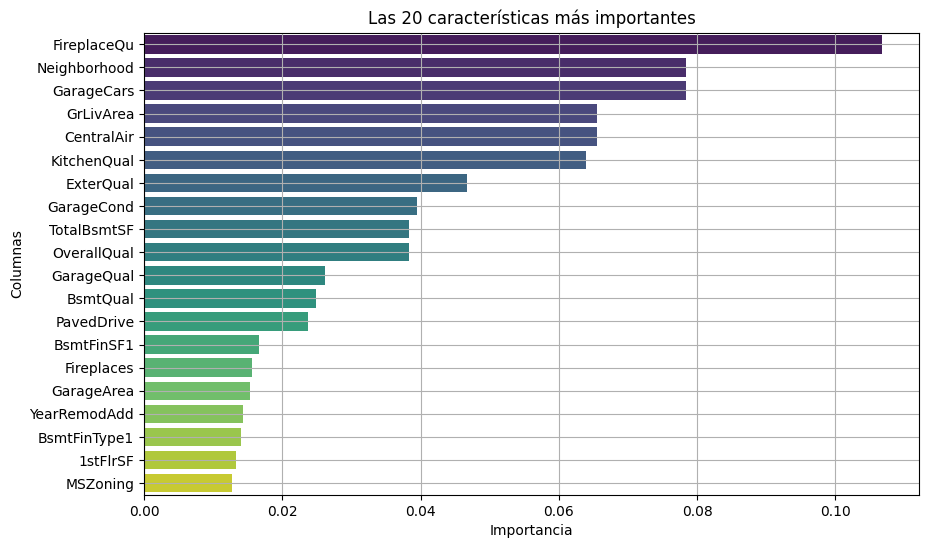

In [103]:
feature_importances(mejor_modelo, X, top_n=20, ascending=False)

### Features menos importantes

Las características se ordenan de forma ascendente para identificar las menos relevantes. Esto facilita el análisis de las variables con menor influencia en las predicciones del modelo y permite valorar su posible eliminación.

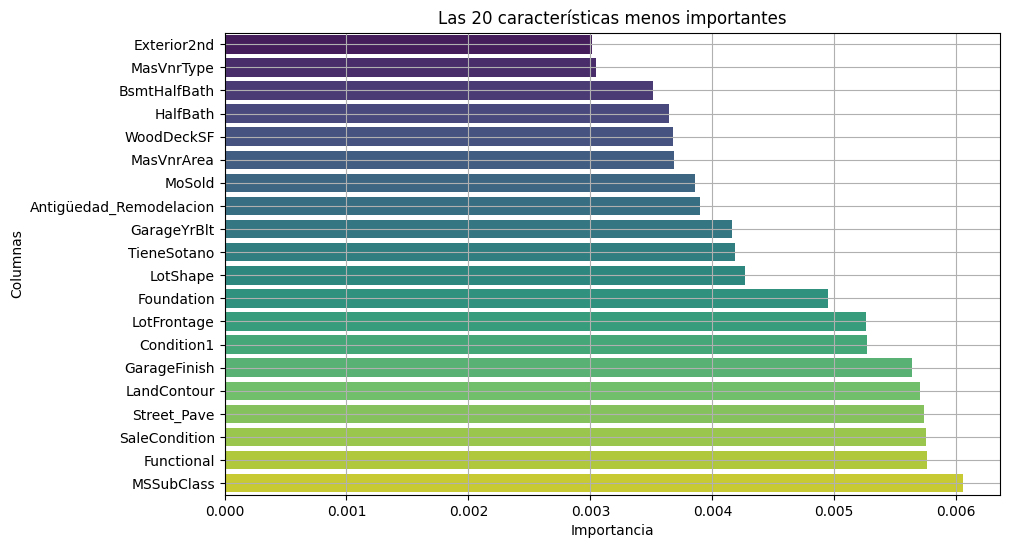

In [104]:
feature_importances(mejor_modelo, X, top_n=20, ascending=True)

### Análisis de la Curva de Aprendizaje

En la curva de aprendizaje del XGBRegressor, se observa que el modelo muestra una buena capacidad de generalización, ya que la diferencia entre las puntuaciones de entrenamiento (rojo) y validación (verde) no es excesiva. A medida que aumenta el tamaño del conjunto de entrenamiento, la puntuación de validación mejora y se estabiliza, lo que indica que el modelo no está sufriendo de sobreajuste (overfitting).

Sin embargo, la curva de validación sigue siendo más alta que la de entrenamiento, lo que sugiere que el modelo podría beneficiarse de ajustes adicionales en sus hiperparámetros para reducir el error en datos no vistos. Además, la ligera variabilidad en la curva de validación, representada por la banda sombreada, indica que el modelo aún puede ser sensible a ciertos patrones en los datos.

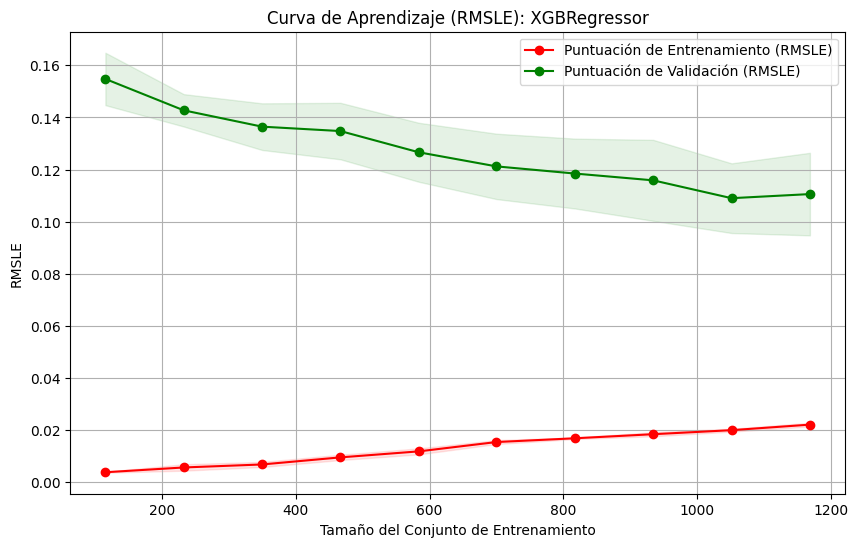

In [105]:
graficar_curva_aprendizaje_rmsle(mejor_modelo, X, y)

# Modelo Final: **XGBRegressor**

Aplicación de Hiperparámetros al Conjunto de Test. En el proceso de ajuste de hiperparámetros, se redujo la complejidad del modelo seleccionando únicamente los valores más relevantes para mejorar su rendimiento.

Carga de los datos de entrenamiento y prueba desde archivos pickle

In [ ]:
train= pd.read_pickle('../data/train.pkl')
test= pd.read_pickle('../data/test.pkl')

In [ ]:
train.drop(columns=columnas_eliminar, inplace=True)
test.drop(columns=columnas_eliminar, inplace=True)

Separación las características (X) y la variable objetivo (y) para el conjunto de entrenamiento, eliminando las columnas `SalePrice` e `Id` de `X_train` y asignando `SalePrice` a `y_train`.

In [ ]:
X_train = train.drop(['SalePrice', 'Id'], axis=1)  
y_train = train['SalePrice']  

Se guarda la columna `Id` antes de eliminarla para luego guardar las predicciones.

In [ ]:
test_ids = test['Id'].copy()

Se crea **`X_test`** sin la columna `Id` para el modelo

In [ ]:
X_test = test.drop(['SalePrice', 'Id'], axis=1)

Se aplica la transformación logarítmica a la target.

In [ ]:
y_train = np.log1p(y_train)

Se definieron los parámetros del modelo y se procedió a entrenarlo. Antes de aplicar los mejores hiperparámetros obtenidos a través de **Grid Search**, se realizó un ajuste manual final para optimizar aún más el rendimiento del modelo.

In [ ]:
parametros = {
    'base_score': 0.4049,  
    'booster': 'gbtree',
    'learning_rate': 0.0223,  
    'max_depth': 12,  
    'max_leaves': 53, 
    'n_estimators': 439,  
    'subsample': 0.5992, 
    'objective': 'reg:squarederror',
    'colsample_bytree': 0.5349, 
    'gamma': 0.0111, 
    'tree_method': 'auto'
}

modelo = XGBRegressor(**parametros, random_state=42)

modelo.fit(X_train, y_train)

yhat = modelo.predict(X_test)

Reversión de la transformación logarítmica para SalePrice.

In [ ]:
predicciones = np.expm1(yhat)  

### DF de las predicciones

Después de realizar un ciclo iterativo de modelado, en el cual se limpiaron variables, se ajustaron los parámetros del modelo y se mejoró el rendimiento predictivo, se procede a crear un DF de **Submission** con los identificadores de las instancias de prueba y sus respectivas predicciones de precios. 

In [ ]:
df_predicciones = pd.DataFrame({
    'Id': test_ids,  
    'SalePrice': predicciones
})

## Comparación Estadística entre Predicciones y Entrenamiento

Las predicciones del modelo están bastante cerca de los valores reales, con algunas pequeñas diferencias:

- **Promedio**: Las predicciones tienen un promedio de **177,613.95**, ligeramente por debajo de los valores reales (**180,921.20**).
- **Desviación Estándar**: Las predicciones tienen una desviación estándar de **74,106.54**, menor que la de los valores reales (**79,442.50**), indicando menos dispersión.
- **Percentiles**: 
  - 25%: Predicciones (**129,844.17**) vs Reales (**129,975.00**).
  - 50% (Mediana): Predicciones (**156,468.75**) vs Reales (**163,000.00**).
  - 75%: Predicciones (**206,565.28**) vs Reales (**214,000.00**).
- **Máximo**: El valor máximo de las predicciones es **531,618.56**, mientras que el valor máximo real es **755,000.00**, indicando que el modelo tiene dificultades con los valores más altos.

En resumen, las predicciones son bastante cercanas a los valores reales, pero hay margen de mejora en los valores extremos.

In [ ]:
revisar_predicciones(predicciones, test_ids, df_predicciones, train=train)

Coincide el número de predicciones del modelo con las proporcionadas.
No hay valores nulos en SalePrice.
La columna 'Id' no tiene duplicados.
No hay valores negativos en SalePrice.

Comparación estadística entre predicciones y entrenamiento:
        Predicciones  Entrenamiento
count    1459.000000    1460.000000
mean   177613.953125  180921.195890
std     74106.539062   79442.502883
min     47858.496094   34900.000000
25%    129844.171875  129975.000000
50%    156468.750000  163000.000000
75%    206565.281250  214000.000000
max    531618.562500  755000.000000


Se guardan las predicciones generadas por el modelo en un archivo CSV.

In [ ]:
df_predicciones.to_csv('../outputs/predicciones_XGBRegressor.csv', index=False) 

![Mejor puntuacion kaggle](../docs/kaggle_puntuacion.png)

# Conclusiones **XGBRegressor** 

Los resultados obtenidos con **XGBRegressor** en este nuevo enfoque muestran que este modelo ha logrado un rendimiento excepcional. La nueva puntuación de **0.12842** ha permitido alcanzar la **posición 608** en la competición de Kaggle, lo que representa una mejora significativa.  

Este modelo no solo optimiza el **RMSLE**, sino que también demuestra una alta precisión en la predicción de los valores más altos de **SalePrice**, un aspecto crucial en esta competencia. La combinación de validación cruzada y un enfoque en valores extremos ha consolidado a **XGBoost** como la mejor opción para este conjunto de datos.  

Cabe destacar que las mejores puntuaciones en este reto corresponden a modelos con valores de **0.00000** o **0.00044**, lo que indica que predicen casi perfectamente este conjunto de datos. Sin embargo, estos modelos probablemente no generalicen bien a datos similares fuera de la competición, ya que es posible que su rendimiento se degrade en escenarios distintos.  

Si bien aún hay margen para mejoras, este resultado demuestra un avance importante y refuerza la idea de que un enfoque meticuloso en la selección de características y el ajuste de hiperparámetros puede marcar una gran diferencia en la competición. Se continuará explorando nuevas estrategias para seguir optimizando el modelo y mejorar su capacidad de generalización.  